Getting Started | Data Prep | Data Exploration | Preprocessing | **Model Tuning** | Final Model

In [1]:
import sys
sys.path.insert(0, '../modules')

# now read in the new function
from helpers import get_data
from preprocessor import Preprocessor

In [22]:
# more imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.metrics import make_scorer, roc_auc_score,classification_report, recall_score, confusion_matrix, precision_recall_curve, f1_score
from sklearn.utils import resample
from imblearn.over_sampling  import SMOTE, ADASYN
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

%matplotlib inline

## Read Data

In [3]:
X_train, y_train = get_data('train')

In [4]:
X_test, y_test = get_data('test')

In [5]:
# Use preprocessor on training data
p = Preprocessor(cols_to_filter=['Competitor Type'])
X_train = p.fit_transform(X_train)

In [6]:
X_test = p.transform(X_test)

In [7]:
# Transform y where 1 = Won and 0=Loss
y_train = pd.get_dummies(y_train, drop_first=True)
y_test = pd.get_dummies(y_test, drop_first=True)

## Class Imbalance

In [8]:
# Check percent of opportunity that were won (1) versus lost (0)
y_train['Won'].value_counts(1)

0    0.775051
1    0.224949
Name: Won, dtype: float64

Text(0, 0.5, 'Count')

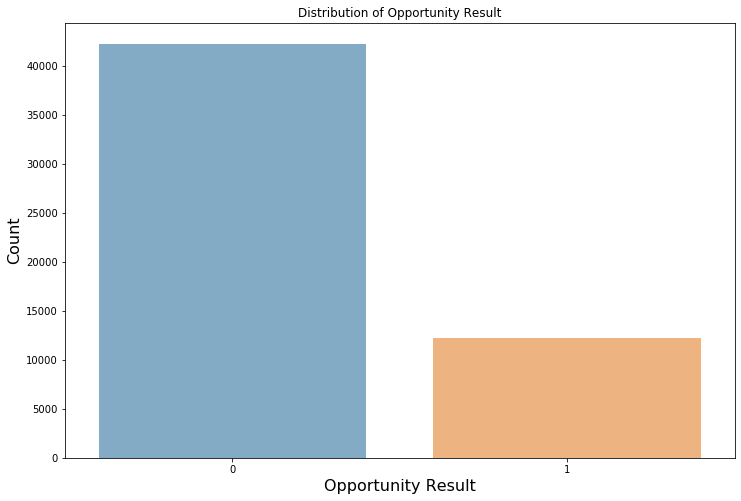

In [9]:
plt.figure(figsize=(12,8))
deal_outcomes = y_train['Won'].value_counts()
sns.barplot(y=deal_outcomes.values, x=deal_outcomes.index, alpha=0.6)
plt.title('Distribution of Opportunity Result')
plt.xlabel('Opportunity Result', fontsize=16)
plt.ylabel('Count', fontsize=16)

In [10]:
# Upsample minority class
X_train_u, y_train_u = resample(X_train[y_train['Won'] == 1],
                                y_train[y_train['Won'] == 1],
                                replace=True,
                                n_samples=X_train[y_train['Won'] == 0].shape[0],
                                                  random_state=1)

X_train_u = np.concatenate((X_train[y_train['Won'] == 0], X_train_u))
y_train_u = np.concatenate((y_train[y_train['Won'] == 0], y_train_u))


# Upsample using SMOTE
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

# Downsample majority class
X_train_d, y_train_d = resample(X_train[y_train['Won'] == 0],
                                y_train[y_train['Won'] == 0],
                                replace=True,
                                n_samples=X_train[y_train['Won'] == 1].shape[0],
                                random_state=1)
X_train_d = np.concatenate((X_train[y_train['Won'] == 1], X_train_d))
y_train_d = np.concatenate((y_train[y_train['Won'] == 1], y_train_d))


print("Original shape:", X_train.shape, y_train.shape)
print("Upsampled shape:", X_train_u.shape, y_train_u.shape)
print ("SMOTE sample shape:", x_train_sm.shape, y_train_sm.shape)
print ("ADASYN sample shape:", x_train_ad.shape, y_train_ad.shape)
print("Downsampled shape:", X_train_d.shape, y_train_d.shape)

/Users/Jaime/miniconda3/envs/classification/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Original shape: (54519, 39) (54519, 1)
Upsampled shape: (84510, 39) (84510, 1)
SMOTE sample shape: (84510, 39) (84510,)


NameError: name 'x_train_ad' is not defined

### Test Methods with Logistic Regression (Using Cross Validation)

In [13]:
#Create Training Sets

methods_train_data = {"Original": (X_train, y_train['Won']),
                "Upsampled": (X_train_u, y_train_u[:,0]),
                "SMOTE":(x_train_sm, y_train_sm),
                "Downsampled": (X_train_d, y_train_d[:,0])}

# 5-Fold cross validation using Logistic Regression
for method in methods_train_data.keys():
    lr_results = cross_val_score(LogisticRegression(solver='lbfgs'), methods_train_data[method][0], methods_train_data[method][1], cv=5, scoring='recall')
    print(f"The best Recall Score for {method} data:")
    print (lr_results.mean())
 
cross_val_score(LogisticRegression(solver='lbfgs',class_weight='balanced'), X_train, y_train['Won'], cv=5, scoring='recall').mean()

The best Recall Score for Original data:
0.08291887484712597
The best Recall Score for Upsampled data:
0.6966749497100934
The best Recall Score for SMOTE data:
0.7782510945450243
The best Recall Score for Downsampled data:
0.6060850348709075


0.727176962789513

# Model Selection

## Logistic Regression

In [14]:
lr = LogisticRegression(solver='lbfgs')

#Fit model
# Fit the model to the Upsampling data
lr = lr.fit(x_train_sm, y_train_sm)

print ("\n\n ---Logistic Regression Model---")
lr_auc = roc_auc_score(y_test['Won'], lr.predict(X_test))

print ("Logistic Regression AUC = %2.2f" % lr_auc)

lr2 = lr.fit(x_train_sm, y_train_sm)
print(classification_report(y_test['Won'], lr.predict(X_test)))



 ---Logistic Regression Model---
Logistic Regression AUC = 0.74
              precision    recall  f1-score   support

           0       0.93      0.66      0.77     18081
           1       0.42      0.82      0.55      5327

    accuracy                           0.70     23408
   macro avg       0.67      0.74      0.66     23408
weighted avg       0.81      0.70      0.72     23408



## Random Forest

In [15]:
# Random Forest Model
rf = RandomForestClassifier()

rf_result = cross_val_score(rf, x_train_sm, y_train_sm, cv=5, scoring='recall')

rf_result.mean()

/Users/Jaime/miniconda3/envs/classification/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Jaime/miniconda3/envs/classification/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Jaime/miniconda3/envs/classification/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Jaime/miniconda3/envs/classification/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in versio

0.8485386344811265

## Gradient Boosting Classifier

In [16]:
gbc = GradientBoostingClassifier()  

gbc = gbc.fit(x_train_sm,y_train_sm)

gbc

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [17]:
# Cross Validation for GBC

gbc_result = cross_val_score(gbc, x_train_sm, y_train_sm, cv=5, scoring='recall')
gbc_result.mean()

0.8497929239143296

# Model Tuning

In [19]:
# Create training and validation dataset
x_train, x_valid, y_train, y_valid = train_test_split(x_train_sm, y_train_sm, test_size = 0.3, random_state=0, shuffle=True)

In [80]:
# Testing

In [120]:
n_estimators = np.arange(400, 1000, 50)
max_depth = [2,4,6]

param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth,}

In [121]:
rfc = RandomForestClassifier()

In [122]:
gs = GridSearchCV(rfc, 
                  param_grid, 
                  cv=3,
                  n_jobs=-1,
                  scoring=make_scorer(recall_score))

In [123]:
gs.fit(x_train_sm,y_train_sm)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [113]:
# View best recall score and parameters
print('Best score for data1:', gs.best_score_) 
print('Best Parameters:',gs.best_params_)

Best score for data1: 0.8429061649508934
Best Parameters: {'max_depth': 4, 'n_estimators': 500}


In [116]:
mean_score = gs.cv_results_['mean_test_score']
params = gs.cv_results_['params']

In [119]:
params

[{'max_depth': 2, 'n_estimators': 200},
 {'max_depth': 2, 'n_estimators': 500},
 {'max_depth': 4, 'n_estimators': 200},
 {'max_depth': 4, 'n_estimators': 500},
 {'max_depth': 6, 'n_estimators': 200},
 {'max_depth': 6, 'n_estimators': 500}]

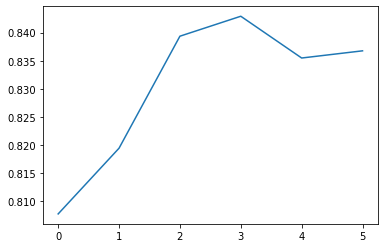

In [118]:
plt.plot(zip(mean_score)

In [67]:
def select_params(X, y, max_estimators=1000, max_depth = 3, learning_rate=0.01):
    

    # Create validation set
    #X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=0, shuffle=True)
    

    gbc = GradientBoostingClassifier(n_estimators = max_estimators,
                                     learning_rate=learning_rate, 
                                     max_depth=max_depth, 
                                     loss='deviance',
                                     subsample=0.5)
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
    #n_estimators = [max_estimators for d in depth]
    
    param_grid = dict(max_depth=depth)
    
    grid_search = GridSearchCV(gbc, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
    grid_result = grid_search.fit(X, y)
    
    # Results
    print('best Score: {0}'.format(grid_result.best_score_))
    print('optimal parameters: {}'.format(grid_result.best_params_))
    
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    
    for mean, stdev, param in zip(means, stds, params):
        print("mean: {}    std:{}    parameters: {}".format(mean, stdev, param))
    
    #Plot
    scores = numpy.array(means).reshape(len(max_depth), len(n_estimators))
    for i, value in enumerate(max_depth):
        plt.plot(n_estimators, scores[i], label='depth: ' + str(value))
    plt.legend()
    plt.xlabel('n_estimators')
    plt.ylabel('Log Loss')
    #plt.savefig('n_estimators_vs_max_depth.png')